## Comparing B-cell predictions

Here, we reproduce the heatmaps from Figure 3CD & calculate the p-values mentioned in the text.

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, wilcoxon
import seaborn as sns
from statsmodels.stats.multitest import multipletests 

matplotlib.rcParams['pdf.fonttype'] = 42


#### Heatmap Figure 3C

In [2]:
def cp_diffdataset(tissue_true, tissue_pred, ct, protocol):
    
    # Find index of celltype in true tissue
    filename_true = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue_true + '/pseudobulk.csv'
    celltypes = np.array(pd.read_csv(filename_true, index_col=0).columns, dtype='str')
    ct_true = np.where(celltypes == ct)[0]
    
    # Find index of celltype in predicted tissue
    filename_pred = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue_pred + '/pseudobulk.csv'
    celltypes = np.array(pd.read_csv(filename_pred, index_col=0).columns, dtype='str')
    ct_pred = np.where(celltypes == ct)[0]
    
    corr_folds = np.zeros((20,))
    
    for i in range(0,20):
        
        y_pred = 0
        
        file = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue_true + '/cp_specific/logmean_zscore_multitask_' + str(i) + '/logs_dir' + str(0) + '/results_testdata_best.pkl'
        y = pd.read_pickle(file)
        y_true = np.asarray(y['y_true'])[:,ct_true-1]
        
        for j in range(5):
        
            file = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue_pred + '/cp_specific/logmean_zscore_multitask_' + str(i) + '/logs_dir' + str(j) + '/results_testdata_best.pkl'
            y = pd.read_pickle(file)
            y_pred = y_pred + np.asarray(y['y_pred'])[:,ct_pred-1]/5
            
        x,_ = pearsonr(np.squeeze(y_pred), np.squeeze(y_true))
        corr_folds[i] = x
             
    return np.median(corr_folds)

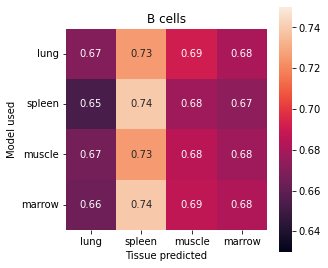

In [3]:
ct = 'B cell'
tissues = ['lung', 'spleen', 'muscle', 'marrow']

# Columns = model used
# Index = what we want to predict
corr2 = pd.DataFrame(data=np.zeros((len(tissues),len(tissues))),
                        columns=tissues,
                        index=tissues)

for t in tissues:
    for t2 in tissues:
        corr2.loc[t][t2] = cp_diffdataset(t, t2, ct, 'FACS_SM2')

plt.figure(figsize=(4.5,4.5))
sns.heatmap(corr2.T, annot=True, vmin=0.63, vmax=0.75, square=True)
plt.title('B cells')
plt.yticks(rotation=0)
plt.ylabel('Model used')
plt.xlabel('Tissue predicted')

plt.show()       

#### Heatmap Figure 3D

In [4]:
def compare_model(tissue, protocol):
    
    cp = pd.read_csv('../../Zenodo/mouse/TM_' + protocol + '/' + tissue + '/pseudobulk.csv', index_col = 0).columns[1:]
    
    corr_all_folds = np.zeros((20,len(cp),len(cp)))
    
    for i in range(0,20):
        
        y_pred = 0
        
        file = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue + '/cp_specific/logmean_zscore_multitask_' + str(i) + '/logs_dir' + str(0) + '/results_testdata_best.pkl'
        y = pd.read_pickle(file)
        y_true = np.asarray(y['y_true'])
        
        for j in range(5):
        
            file = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue + '/cp_specific/logmean_zscore_multitask_' + str(i) + '/logs_dir' + str(j) + '/results_testdata_best.pkl'
            y = pd.read_pickle(file)
            y_pred = y_pred + np.asarray(y['y_pred'])/5
        
        corr = pd.DataFrame(np.hstack((y_pred, y_true))).corr().iloc[len(cp):,:len(cp)]
        corr_all_folds[i] = corr
        
    corr = np.median(corr_all_folds, axis=0)
    corr = pd.DataFrame(corr, index = cp, columns=cp)

    return corr, corr_all_folds

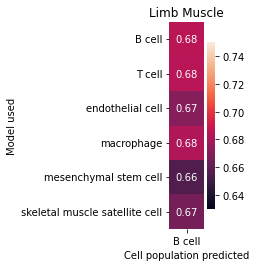

In [5]:
#Figure 3D - Make heatmap for limb muscle

plt.figure(figsize=(1,3.8))

corr, corr_all_folds = compare_model('muscle', 'FACS_SM2')
corr = pd.DataFrame(corr.loc['B cell'])
sns.heatmap(corr, annot=True, vmin=0.63, vmax=0.75, square=True)
plt.ylabel('Model used')
plt.xlabel('Cell population predicted')
plt.title('Limb Muscle')
plt.show()

In [6]:
## Wilcoxon rank sum test
## Hypothesis: B cell model outperforms other models
corr_all_folds_B = corr_all_folds[:,0]
B = corr_all_folds_B[:,0]
pvalues = np.zeros((5,))
medians = np.zeros((5,))

for i in range(5):
    other = corr_all_folds_B[:,i+1]
    medians[i] = np.median(other)
    _, p = wilcoxon(B, other, alternative='greater')
    pvalues[i] = p

pvalues = pd.DataFrame(pvalues, index=corr.index[1:], columns = ['pvalue'])
pvalues

,pvalue
T cell,4.865360e-02
endothelial cell,9.536743e-07
macrophage,4.768372e-06
mesenchymal stem cell,9.536743e-07
skeletal muscle satellite cell,9.536743e-07
